In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from DeepEEG.input_preparation import get_labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model



2024-01-05 17:12:41.212596: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 17:12:41.215480: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 17:12:41.241557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 17:12:41.241581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 17:12:41.242356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Define a function to load data from multiple files
def load_activity_data(activity, file_prefix, num_files):
    data_list = []
    for i in range(1, num_files + 1):
        file_path = f"Data/{activity}/{file_prefix} {i}cleaned.csv"
        data = np.genfromtxt(file_path, delimiter=',')
        data_list.append(data)
    return np.concatenate(data_list, axis=0)

In [3]:

# Load data for each activity
reading_data = load_activity_data("Reading", "r", 6)
speaking_data = load_activity_data("Speaking", "s", 4)
watching_data = load_activity_data("Watching", "w", 6)

In [4]:
# Create labels for each activity
reading_labels = np.full((reading_data.shape[0],), 
                         fill_value=0)  # 0 represents reading
speaking_labels = np.full((speaking_data.shape[0],),
                           fill_value=1)  # 1 represents speaking
watching_labels = np.full((watching_data.shape[0],),
                           fill_value=2)  # 2 represents watching


In [26]:

# Concatenate data and labels
X = np.concatenate((reading_data, speaking_data, watching_data), axis=0)
y = np.concatenate((reading_labels, speaking_labels, watching_labels), axis=0)
#X = pd.DataFrame(X)
#y = pd.DataFrame(y)


(104480, 5)

In [6]:
# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
test_size=0.2, random_state=42)


In [8]:

# Reshape data for LSTM (assuming data is 1D, modify as needed if your data has more dimensions)
X_train_reshaped = X_train.reshape(X_train.shape[0], 
                                   X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0],
                                  X_test.shape[1], 1)

In [9]:
X_train_reshaped.shape

(83584, 5, 1)

In [10]:
# Build an LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train_reshaped.shape[1], 
                                         X_train_reshaped.shape[2]),
                                         return_sequences=True),
    tf.keras.layers.LSTM(units=32),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  
    # 3 output neurons for 3 classes (reading, speaking, watching)
])



modedl_LSTM = plot_model(model, to_file='model_LSTM.png', show_shapes=True)


2024-01-05 17:12:43.531228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-05 17:12:43.532106: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
# Compile the model
model.compile(optimizer=Adam(0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped,
                     y_train, epochs=20, batch_size=32, 
validation_data=(X_test_reshaped, y_test))

Epoch 1/20


2612/2612 [==============================] - 13s 4ms/step - loss: 0.6464 - accuracy: 0.7437 - val_loss: 0.5163 - val_accuracy: 0.8101
Epoch 2/20
2612/2612 [==============================] - 11s 4ms/step - loss: 0.4697 - accuracy: 0.8206 - val_loss: 0.4045 - val_accuracy: 0.8509
Epoch 3/20
2612/2612 [==============================] - 12s 5ms/step - loss: 0.3942 - accuracy: 0.8531 - val_loss: 0.4493 - val_accuracy: 0.8243
Epoch 4/20
2612/2612 [==============================] - 14s 5ms/step - loss: 0.3643 - accuracy: 0.8626 - val_loss: 0.3110 - val_accuracy: 0.8873
Epoch 5/20
2612/2612 [==============================] - 20s 8ms/step - loss: 0.3523 - accuracy: 0.8650 - val_loss: 0.3300 - val_accuracy: 0.8756
Epoch 6/20
2612/2612 [==============================] - 18s 7ms/step - loss: 0.3345 - accuracy: 0.8723 - val_loss: 0.3267 - val_accuracy: 0.8729
Epoch 7/20
2612/2612 [==============================] - 18s 7ms/step - loss: 0.3303 - accuracy: 0.8725 - val_loss: 0.3053 - val_accuracy: 0.8

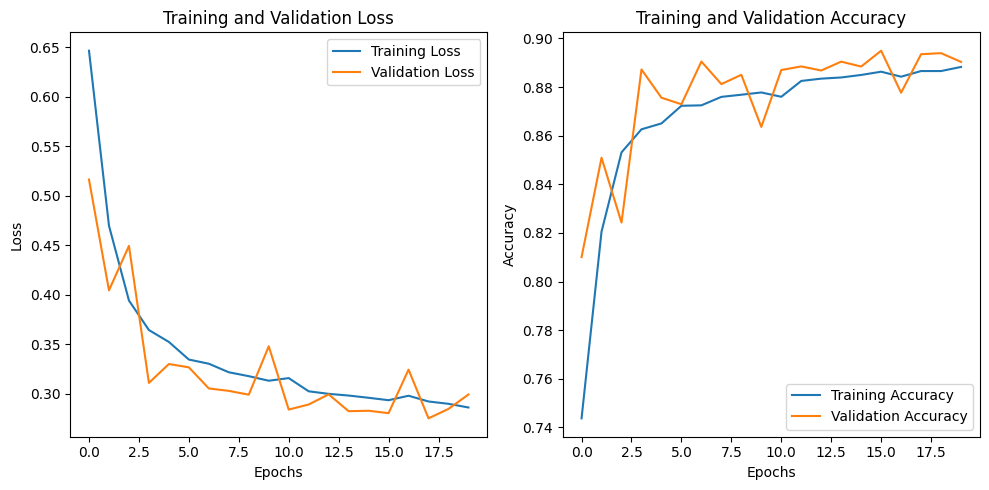

In [17]:
# Plotting loss for training and validation data
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy for training and validation data
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Make predictions on the test set
predictions = model.predict(X_test_reshaped)

# Decode labels if necessary
decoded_true_labels = label_encoder.inverse_transform(y_test)
decoded_predicted_labels = label_encoder.inverse_transform(np.argmax(predictions,
                             axis=1))

# Create a Pandas DataFrame with true labels and predicted labels
df = pd.DataFrame({'True Label': decoded_true_labels, 
        'Predicted Label': decoded_predicted_labels})

# Display the DataFrame
print(df)

653/653 [==============================] - 1s 1ms/step
       True Label  Predicted Label
0               2                2
1               2                2
2               1                1
3               0                0
4               0                0
...           ...              ...
20891           2                2
20892           0                0
20893           0                0
20894           0                0
20895           0                0

[20896 rows x 2 columns]


In [32]:
Labels = get_labels("Data")

def labels(my_dict):
    labels = np.array(list(my_dict.keys()))
    return labels


labels = labels(Labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_encoded, labels

(array([1, 0, 2]), array(['Speaking', 'Reading', 'Watching'], dtype='<U8'))

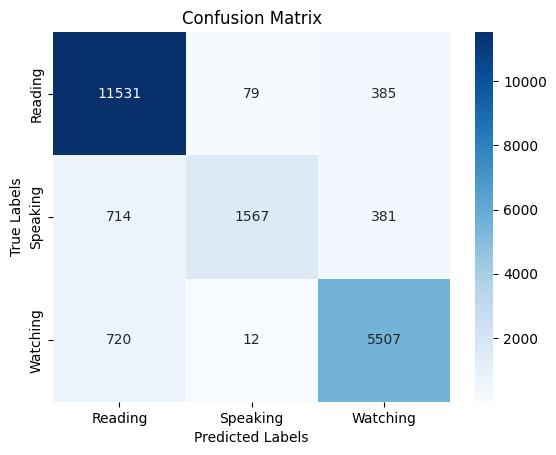

In [33]:
conf_matrix = confusion_matrix(decoded_true_labels, decoded_predicted_labels)
class_labels = label_encoder.classes_

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



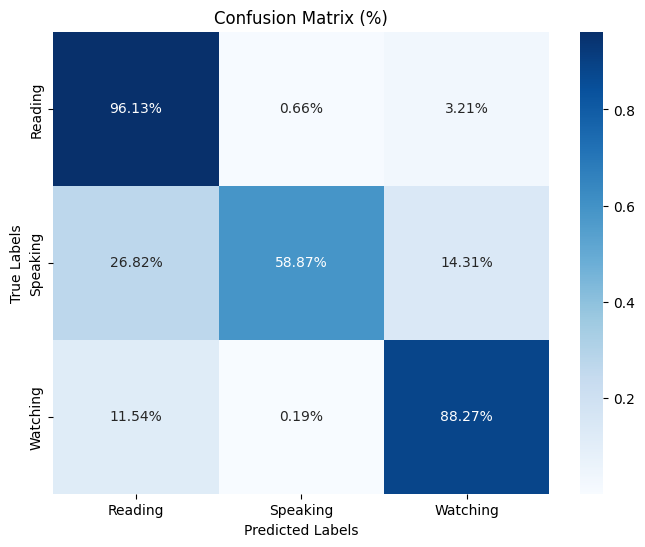

In [34]:
# Calculate confusion matrix with counts
conf_matrix = confusion_matrix(decoded_true_labels, decoded_predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2%',  xticklabels=class_labels, yticklabels=class_labels  )

# Labeling and visualization settings
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()
